In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
# !pip install optuna
# !pip install mlflow
import optuna
import mlflow
import mlflow.sklearn
import warnings
from datetime import datetime

In [4]:
file_path = '/content/drive/MyDrive/ML Ops/Assignment 2/indian_liver_patientmissing.csv'
df = pd.read_csv(file_path)

In [5]:
numeric_cols = ['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
                          'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,LiverPateientOrNot 1meansNO
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [6]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Basic Stats for Numeric Features:")
print(df[numeric_cols].describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nValue Counts for Gender:")
print(df['Gender'].value_counts())

print("\nLiver Patient Distribution:")
print(df['LiverPateientOrNot 1meansNO'].value_counts())


Basic Stats for Numeric Features:
              Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
count  583.000000       580.000000        579.000000            582.000000   
mean    44.746141         3.303448          1.487392            290.591065   
std     16.189833         6.222844          2.816363            243.146707   
min      4.000000         0.400000          0.100000             63.000000   
25%     33.000000         0.800000          0.200000            175.250000   
50%     45.000000         1.000000          0.300000            208.000000   
75%     58.000000         2.600000          1.300000            298.000000   
max     90.000000        75.000000         19.700000           2110.000000   

       Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
count                580.000000                  580.000000      581.000000   
mean                  80.387931                  109.003448        6.489329   
std                  182.9

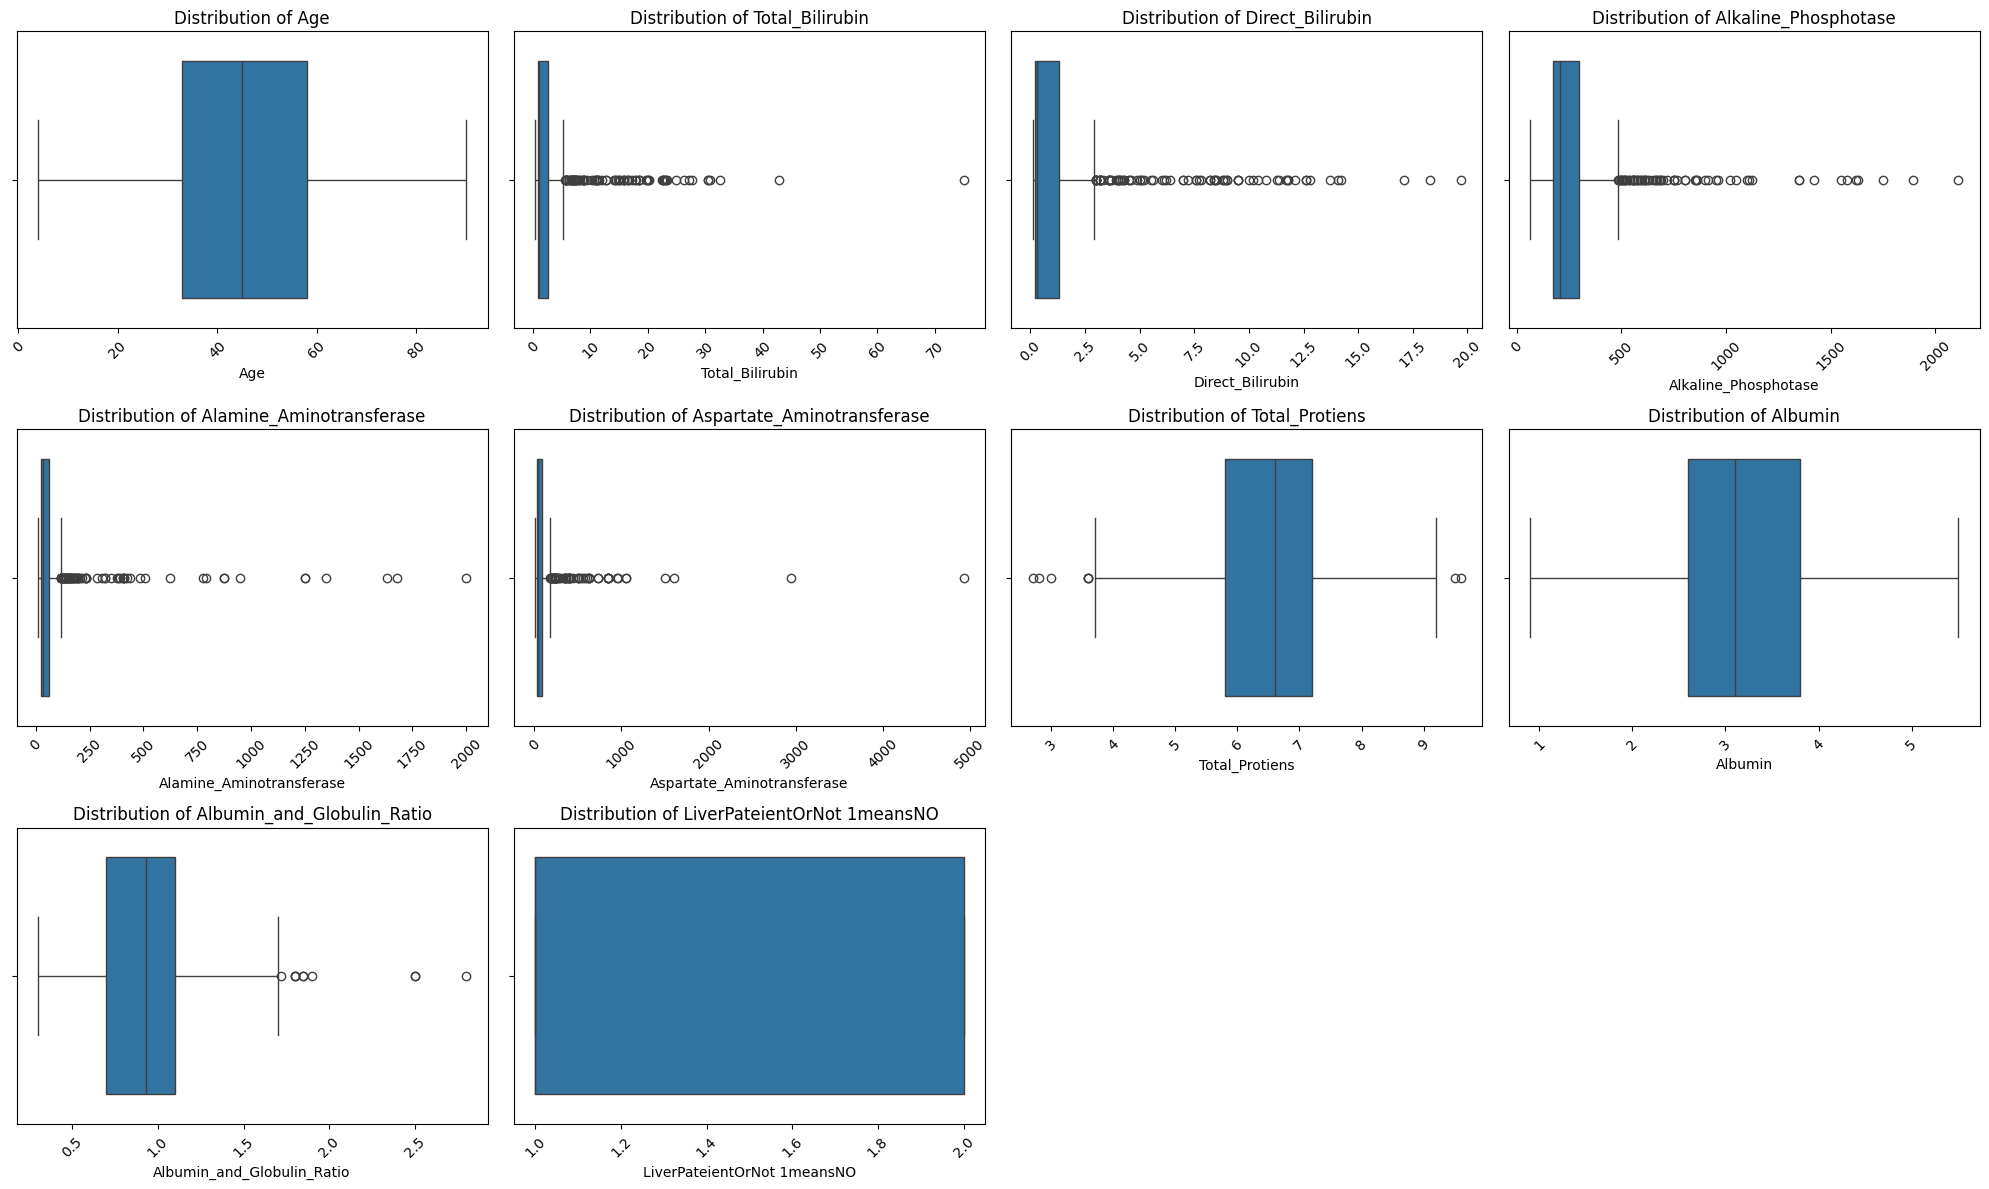

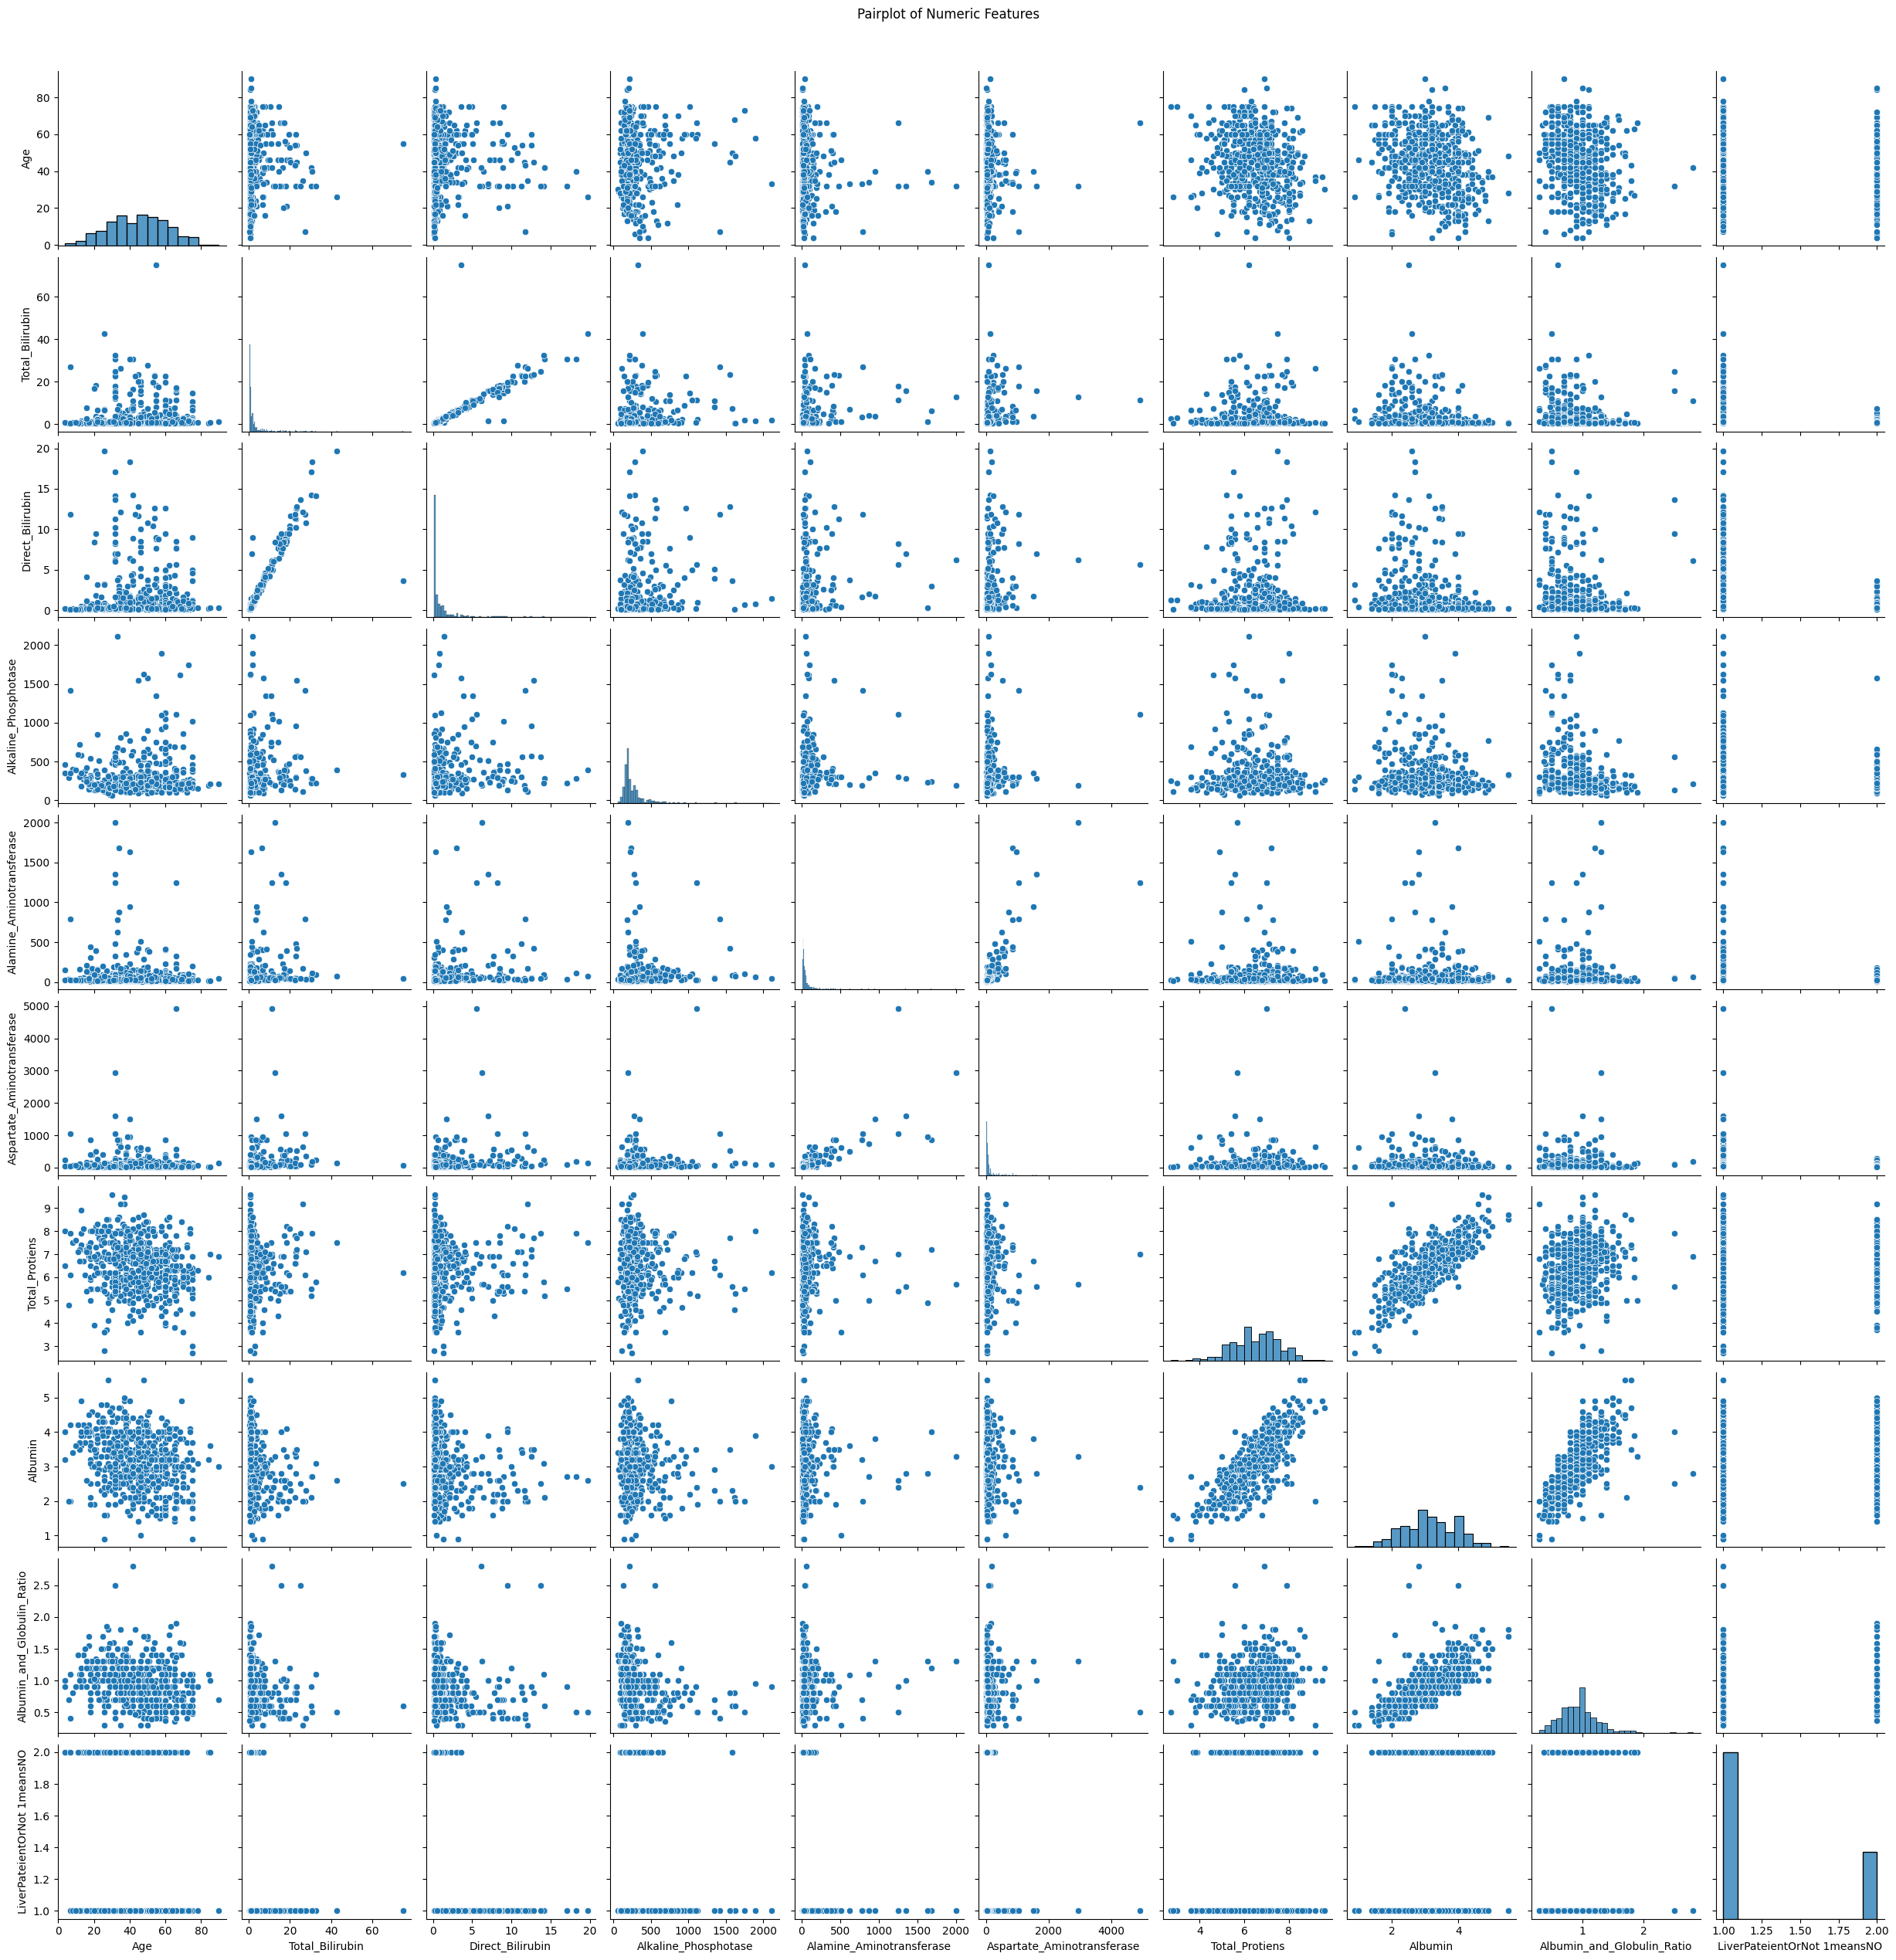

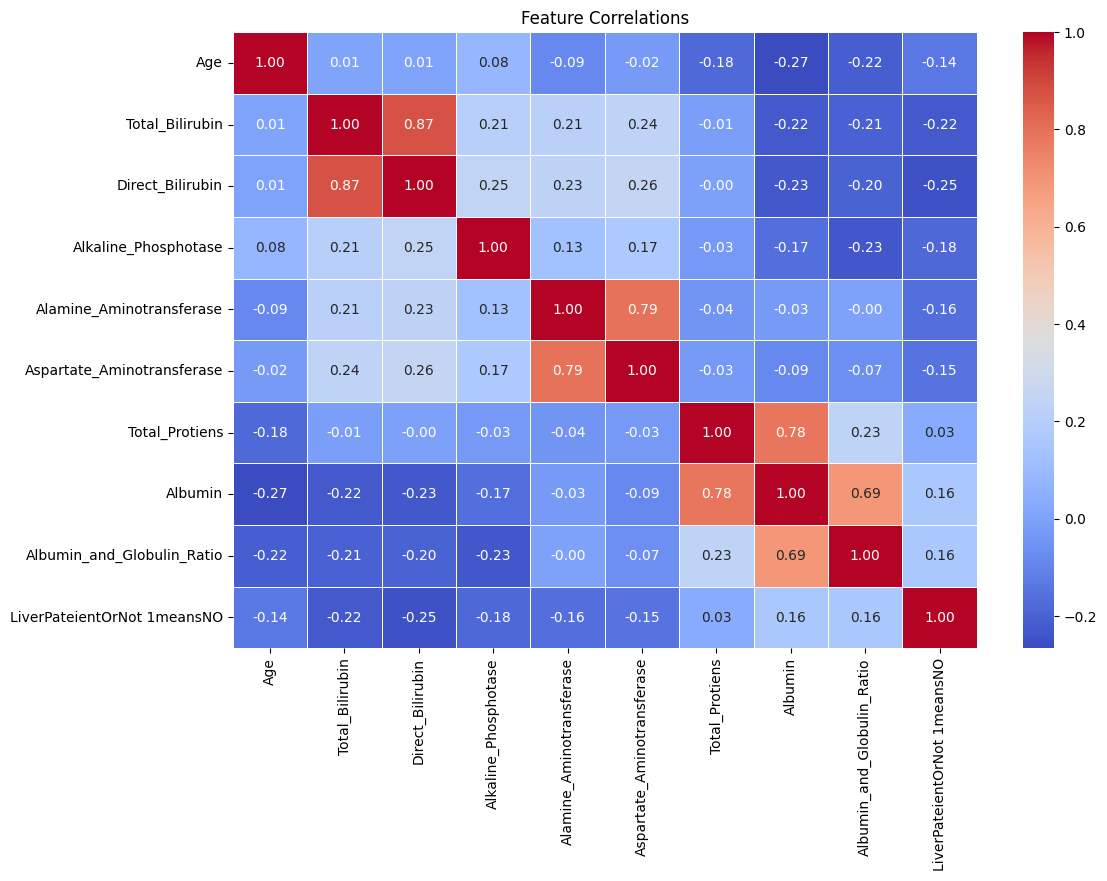

In [7]:
# Using Boxplots for distribution visualization
plt.figure(figsize=(20, 12))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, idx)
    sns.boxplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Using Pairplot to visualize relationships between numeric features
sns.pairplot(df[numeric_cols])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

# Using Heatmap for feature correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlations")
plt.show()


In [11]:
processed_df = df.copy()

# Encode 'Gender' column using LabelEncoder
processed_df['Gender'] = LabelEncoder().fit_transform(processed_df['Gender'])

# Fill missing values with the median of each column
processed_df = processed_df.fillna(processed_df.median())

# Separate features (X) and target variable (y)
X = processed_df.drop('LiverPateientOrNot 1meansNO', axis=1)
y = processed_df['LiverPateientOrNot 1meansNO']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



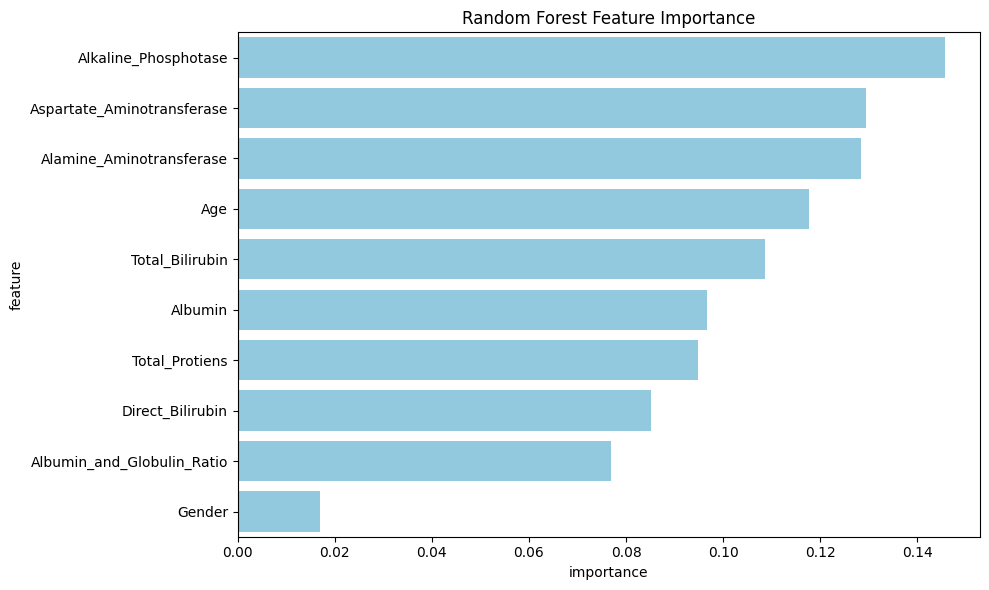

In [13]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Use the scaled variables with the correct suffix
forest.fit(X_train_scaled, y_train)

# Calculate feature importance and create a DataFrame
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': forest.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the feature importance with a different color (e.g., 'skyblue')
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', color='skyblue')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()



In [15]:
# Function to optimize the Decision Tree model
def optimize_decision_tree(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    # Initialize the Decision Tree model with trial parameters
    model = DecisionTreeClassifier(**params, random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model and return the accuracy
    return accuracy_score(y_test, model.predict(X_test_scaled))

# Create and run the optimization study
study_tree = optuna.create_study(direction='maximize')
study_tree.optimize(optimize_decision_tree, n_trials=50)

# Output the best parameters and score found
print("Best Decision Tree Parameters:", study_tree.best_params)
print("Best Score:", study_tree.best_value)

[I 2024-12-15 15:00:29,115] A new study created in memory with name: no-name-c0e16c6b-f323-4ce8-98d1-82be85972805
[I 2024-12-15 15:00:29,136] Trial 0 finished with value: 0.7008547008547008 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7008547008547008.
[I 2024-12-15 15:00:29,151] Trial 1 finished with value: 0.7350427350427351 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7350427350427351.
[I 2024-12-15 15:00:29,165] Trial 2 finished with value: 0.7094017094017094 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7350427350427351.
[I 2024-12-15 15:00:29,184] Trial 3 finished with value: 0.7435897435897436 and parameters: {'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.7435897435897436.
[I 2024-12-15 15:00:29,196] Trial 4 finished with value: 0.67521

Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9}
Best Score: 0.7777777777777778


In [18]:
# Function to optimize the Random Forest model
def optimize_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    # Initialize the Random Forest model with trial parameters
    model = RandomForestClassifier(**params, random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model and return the accuracy
    return accuracy_score(y_test, model.predict(X_test_scaled))

# Create and run the optimization study
study_forest = optuna.create_study(direction='maximize')
study_forest.optimize(optimize_random_forest, n_trials=50)

# Output the best parameters and score found
print("Best Random Forest Parameters:", study_forest.best_params)
print("Best Score:", study_forest.best_value)

[I 2024-12-15 15:04:38,741] A new study created in memory with name: no-name-072ddfec-bf4b-4a90-adc8-909ef34899c2
[I 2024-12-15 15:04:40,132] Trial 0 finished with value: 0.717948717948718 and parameters: {'n_estimators': 286, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.717948717948718.
[I 2024-12-15 15:04:40,526] Trial 1 finished with value: 0.717948717948718 and parameters: {'n_estimators': 123, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.717948717948718.
[I 2024-12-15 15:04:40,867] Trial 2 finished with value: 0.717948717948718 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.717948717948718.
[I 2024-12-15 15:04:41,161] Trial 3 finished with value: 0.7350427350427351 and parameters: {'n_estimators': 93, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.7

Best Random Forest Parameters: {'n_estimators': 68, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9}
Best Score: 0.7777777777777778


In [20]:
# Apply PCA to reduce dimensions, keeping 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the models using the best parameters found by Optuna for Decision Tree and Random Forest
models = {
    'Decision Tree': DecisionTreeClassifier(**study_tree.best_params),
    'Random Forest': RandomForestClassifier(**study_forest.best_params),
    'Decision Tree with PCA': DecisionTreeClassifier(**study_tree.best_params),
    'Random Forest with PCA': RandomForestClassifier(**study_forest.best_params)
}

# Dictionary to store the results
results = {}
for name, model in models.items():
    if 'PCA' in name:
        model.fit(X_train_pca, y_train)
        score = model.score(X_test_pca, y_test)
    else:
        model.fit(X_train_scaled, y_train)
        score = model.score(X_test_scaled, y_test)
    results[name] = score

# Create a DataFrame to display the results
results_df = pd.DataFrame({'Model': list(results.keys()), 'Accuracy': list(results.values())})
print(results_df)

                    Model  Accuracy
0           Decision Tree  0.777778
1           Random Forest  0.726496
2  Decision Tree with PCA  0.760684
3  Random Forest with PCA  0.743590


In [21]:
# Define experiment name and MLflow tracking URI
experiment_name = "liver_disease_prediction"
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Check if the experiment exists, if not, create it
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

# Set the experiment
mlflow.set_experiment(experiment_name)

2024/12/15 15:05:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/12/15 15:05:39 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/content/mlruns/1', creation_time=1734275141479, experiment_id='1', last_update_time=1734275141479, lifecycle_stage='active', name='liver_disease_prediction', tags={}>

In [27]:

# Start an MLflow run with a dynamic name based on the current timestamp
with mlflow.start_run(run_name=f"decision_tree_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    # Instantiate the DecisionTree model with the best parameters found by Optuna
    dt = DecisionTreeClassifier(**study_tree.best_params, random_state=42)

    dt.fit(X_train_scaled, y_train)


    dt_preds = dt.predict(X_test_scaled)

    dt_accuracy = accuracy_score(y_test, dt_preds)
    dt_cm = confusion_matrix(y_test, dt_preds)

    # Log the hyperparameters (best params from Optuna)
    mlflow.log_params(study_tree.best_params)

    # Log the accuracy as a metric
    mlflow.log_metric("accuracy", dt_accuracy)

    # Plot the confusion matrix and save the image
    plt.figure(figsize=(8, 6))
    sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Decision Tree Confusion Matrix")
    plt.savefig("dt_confusion_matrix.png")  # Save the confusion matrix plot
    mlflow.log_artifact("dt_confusion_matrix.png")  # Log the confusion matrix plot as an artifact
    plt.close()  # Close the plot to avoid display during logging

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(dt, "decision_tree_model")

# Output the decision tree accuracy to the console
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

2024/12/15 15:09:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree Accuracy: 0.7778


In [28]:
# Start an MLflow run with a dynamic name based on the current timestamp
with mlflow.start_run(run_name=f"random_forest_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    # Instantiate the Random Forest model with the best parameters from Optuna
    rf = RandomForestClassifier(**study_forest.best_params, random_state=42)

    # Train the model
    rf.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    rf_preds = rf.predict(X_test_scaled)

    # Calculate the accuracy and confusion matrix
    rf_accuracy = accuracy_score(y_test, rf_preds)
    rf_cm = confusion_matrix(y_test, rf_preds)

    # Log the hyperparameters (best params from Optuna)
    mlflow.log_params(study_forest.best_params)

    # Log the accuracy as a metric
    mlflow.log_metric("accuracy", rf_accuracy)

    # Plot and save the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Random Forest Confusion Matrix")
    plt.savefig("rf_confusion_matrix.png")
    mlflow.log_artifact("rf_confusion_matrix.png")  # Log the confusion matrix as an artifact
    plt.close()  # Close the plot to avoid display during logging

    # Calculate and plot feature importances
    # Use X_train_g23ai2017 instead of X_train
    feature_imp_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")  # Log feature importance plot as an artifact
    plt.close()  # Close the plot

    # Log the trained Random Forest model to MLflow
    mlflow.sklearn.log_model(rf, "random_forest_model")

# Output the random forest accuracy to the console
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


2024/12/15 15:15:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Accuracy: 0.7778


In [29]:
with mlflow.start_run(run_name=f"pca_models_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    # Instantiate the models using the best parameters from Optuna
    dt_pca = DecisionTreeClassifier(**study_tree.best_params, random_state=42)
    rf_pca = RandomForestClassifier(**study_forest.best_params, random_state=42)

    # Train the models on the PCA-transformed training data
    dt_pca.fit(X_train_pca, y_train)
    rf_pca.fit(X_train_pca, y_train)

    # Evaluate the models on the PCA-transformed test data
    dt_pca_accuracy = accuracy_score(y_test, dt_pca.predict(X_test_pca))
    rf_pca_accuracy = accuracy_score(y_test, rf_pca.predict(X_test_pca))

    # Log the accuracy metrics for both models
    mlflow.log_metrics({
        "dt_pca_accuracy": dt_pca_accuracy,
        "rf_pca_accuracy": rf_pca_accuracy
    })

    # Log PCA-related parameters
    mlflow.log_param("n_components", pca.n_components_)
    mlflow.log_param("explained_variance_ratio", sum(pca.explained_variance_ratio_))

    # Log the trained models to MLflow
    mlflow.sklearn.log_model(dt_pca, "decision_tree_pca_model")
    mlflow.sklearn.log_model(rf_pca, "random_forest_pca_model")

# Output the accuracy of the models to the console
print(f"Decision Tree with PCA  Accuracy: {dt_pca_accuracy:.4f}")
print(f"Random Forest with PCA  Accuracy: {rf_pca_accuracy:.4f}")


2024/12/15 15:18:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/15 15:18:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree with PCA  Accuracy: 0.7607
Random Forest with PCA  Accuracy: 0.7436


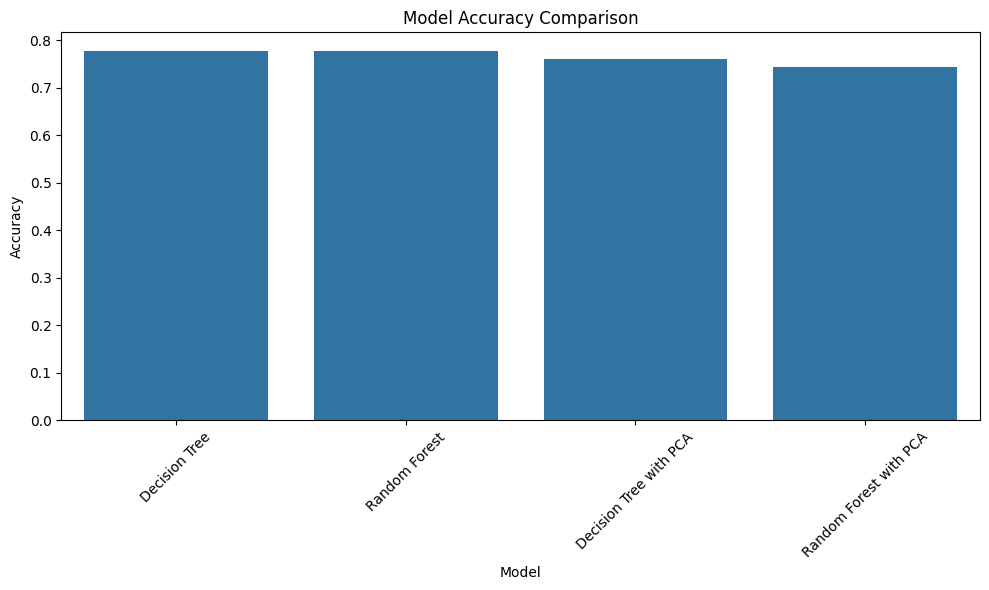


Model Performance Summary:
                    Model  Accuracy
0           Decision Tree  0.777778
1           Random Forest  0.777778
2  Decision Tree with PCA  0.760684
3  Random Forest with PCA  0.743590


In [30]:
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Decision Tree with PCA', 'Random Forest with PCA'],
    'Accuracy': [dt_accuracy, rf_accuracy, dt_pca_accuracy, rf_pca_accuracy]
})

# Plotting the comparison of model accuracies
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the summary of model performance sorted by accuracy
print("\nModel Performance Summary:")
print(results_df.sort_values('Accuracy', ascending=False))

In [31]:
experiment_name = "liver_disease_prediction"
best_run = mlflow.search_runs(
    experiment_names=[experiment_name],
    order_by=["metrics.accuracy DESC"]
).iloc[0]

print("Best Model Performance:")
try:
    print(f"Run ID: {best_run['run_id']}")
    print(f"Model: {best_run['tags.mlflow.runName']}")
    print(f"Accuracy: {best_run['metrics.accuracy']:.4f}")
except KeyError as e:
    print(f"Error: Missing key in MLflow run data: {e}")

print("\nParameters used:")
try:
    params = {k.replace('params.', ''): v for k, v in best_run.items() if k.startswith('params.')}
    for param, value in params.items():
        print(f"{param}: {value}")
except KeyError as e:
    print(f"Error: Missing key in MLflow run parameters: {e}")

Best Model Performance:
Run ID: 19fd364bc8e5474398003281fd389d3f
Model: random_forest_20241215_151515
Accuracy: 0.7778

Parameters used:
max_depth: 4
min_samples_leaf: 9
min_samples_split: 8
n_estimators: 68
explained_variance_ratio: None
n_components: None


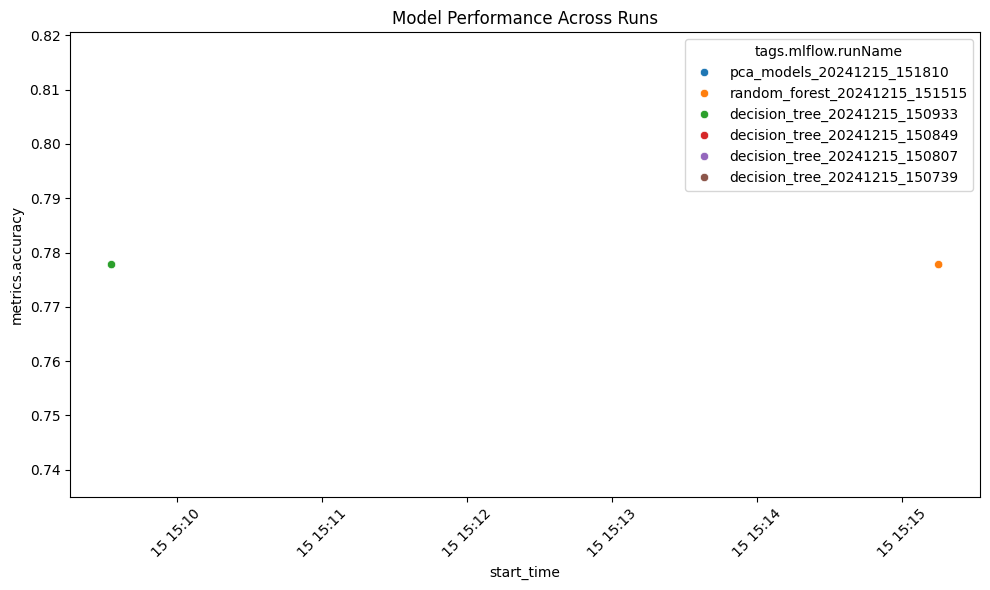


Model Performance Summary:
                               Accuracy          
                                   mean std count
Model                                            
decision_tree_20241215_150739       NaN NaN     0
decision_tree_20241215_150807       NaN NaN     0
decision_tree_20241215_150849       NaN NaN     0
decision_tree_20241215_150933  0.777778 NaN     1
pca_models_20241215_151810          NaN NaN     0
random_forest_20241215_151515  0.777778 NaN     1


In [32]:
experiment_name = "liver_disease_prediction"
all_runs = mlflow.search_runs(experiment_names=[experiment_name])

# Check if all_runs is empty before proceeding
if all_runs.empty:
    print("No MLflow runs found for the experiment:", experiment_name)
else:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=all_runs, x='start_time', y='metrics.accuracy', hue='tags.mlflow.runName')
    plt.xticks(rotation=45)
    plt.title('Model Performance Across Runs')
    plt.tight_layout()
    plt.show()

    summary_df = pd.DataFrame({
        'Model': all_runs['tags.mlflow.runName'],
        'Accuracy': all_runs['metrics.accuracy']
    }).groupby('Model').agg(['mean', 'std', 'count'])

    print("\nModel Performance Summary:")
    print(summary_df)